In [166]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, jaccard_score

## Гистограмма

In [167]:
def extract_hist_features(img, n_bins=32):
    flat = img.flatten()
    hist, bin_edges = np.histogram(flat, bins=n_bins, range=(0,256))
    hist = hist.astype(float)
    hist_norm = hist/hist.sum() if hist.sum()>0 else hist
    bin_centers = (np.arange(n_bins)+0.5)*(256/n_bins)
    weighted = np.hstack([np.full(int(h), c) for h,c in zip(hist,bin_centers) if h>0])
    feats = {
        'mean': np.mean(bin_centers),
        'variance': np.var(weighted),
        'std_dev': np.std(weighted),
        'skewness': skew(weighted) if weighted.size>0 else 0,
        'kurtosis': kurtosis(weighted) if weighted.size>0 else 0,
        'energy': np.sum(hist_norm**2),
        'entropy': entropy(hist_norm),
    }
    return feats, hist_norm

## Laws

In [168]:
def laws_energy(img):
    kernels = [
        ([1,4,6,4,1], 'L5'),
        ([-1,-2,0,2,1], 'E5'),
        ([-1,0,2,0,-1], 'S5'),
        ([-1,2,0,-2,1], 'W5'),
        ([1,-4,6,-4,1], 'R5')
    ]
    feats = {}
    img = img.astype(np.float32)
    for k1, n1 in kernels:
        for k2, n2 in kernels:
            kernel = np.outer(k1,k2)
            filtered = cv2.filter2D(img,-1,kernel)
            feats[f"{n1}{n2}"] = np.mean(filtered**2)
    total = sum(feats.values())
    if total>0:
        for k in feats: feats[k] /= total
    return feats


## GLCM

In [169]:
def glcm_features(img):
    img_q = (img//8).astype(np.uint8)
    glcm = graycomatrix(img_q, distances=[1], angles=[0,np.pi/4,np.pi/2,3*np.pi/4], levels=32, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','energy','correlation']
    feats = {p: np.mean(graycoprops(glcm,p)) for p in props}
    return feats


## Датасеты

In [170]:
def prepare_dataset(folder, feature_type='hist', resize=(128,128)):
    X,y = [],[]
    classes = sorted(os.listdir(folder))
    for cls in classes:
        cls_path = os.path.join(folder, cls)
        if not os.path.isdir(cls_path): continue
        for img_file in os.listdir(cls_path):
            img_path = os.path.join(cls_path,img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: continue
            img = cv2.resize(img, resize)
            if feature_type=='hist':
                feats,_ = extract_hist_features(img)
            elif feature_type=='laws':
                feats = laws_energy(img)
            elif feature_type=='glcm':
                feats = glcm_features(img)
            else:
                feats = {}
            X.append(list(feats.values()))
            y.append(cls)
    return np.array(X), np.array(y)


## Обучение классификаторов

In [171]:
def train_classifiers(X,y):
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    X_tr,X_te,y_tr,y_te = train_test_split(X,y_enc,test_size=0.5,random_state=42)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)
    
    classifiers = {
        'knn': KNeighborsClassifier(n_neighbors=1),
        'svm': SVC(kernel='rbf', random_state=42),
        'tree': DecisionTreeClassifier(max_depth=10, random_state=42)
    }
    models = {}
    stats = {}
    for name, clf in classifiers.items():
        clf.fit(X_tr_s, y_tr)
        y_pred = clf.predict(X_te_s)
        models[name] = clf
        stats[name] = {
            'accuracy': accuracy_score(y_te,y_pred),
            'f1_macro': classification_report(y_te,y_pred,output_dict=True)['macro avg']['f1-score']
        }
    return models, scaler, stats, le


## Сегментация

In [172]:
def segment_image_by_texture(image_path, clf, scaler, feature_type, win=32, step=None):
    if step is None: step=win
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    h,w = img.shape
    seg_map = np.zeros((h,w),dtype=np.uint8)
    for y in range(0,h-win+1,step):
        for x in range(0,w-win+1,step):
            patch = img[y:y+win,x:x+win]
            if feature_type=='hist':
                feats,_ = extract_hist_features(patch)
            elif feature_type=='laws':
                feats = laws_energy(patch)
            elif feature_type=='glcm':
                feats = glcm_features(patch)
            else:
                feats={}
            feat_list = list(feats.values())
            pred = clf.predict(scaler.transform([feat_list]))[0]
            seg_map[y:y+win,x:x+win] = pred
    return seg_map,img

def show_segmentation(seg_map,img,title="Segmentation"):
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img,cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(seg_map,cmap='tab10'); plt.title(title); plt.axis('off')
    plt.show()


## Ручная разметка

In [173]:
def manual_mask_from_rgb(img_rgb):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    _,mask = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    mask = (mask>0).astype(np.uint8)
    return mask

def map_top_n_classes(mask,n=4):
    unique, counts = np.unique(mask,return_counts=True)
    top = unique[np.argsort(-counts)[:n]]
    new_mask = np.zeros_like(mask)
    for i,cls in enumerate(top):
        new_mask[mask==cls] = i
    return new_mask

def evaluate_segmentation(manual_mask, pred_mask, orig_img):
    if manual_mask.shape!=pred_mask.shape:
        pred_mask = cv2.resize(pred_mask,(manual_mask.shape[1],manual_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
    accuracy = accuracy_score(manual_mask.flatten(), pred_mask.flatten())
    iou_scores = jaccard_score(manual_mask.flatten(), pred_mask.flatten(),average=None,labels=np.unique(manual_mask))
    print(f"Accuracy: {accuracy:.3%}")
    print("IoU per class:")
    for i,cls in enumerate(np.unique(manual_mask)):
        print(f"  Class {cls}: {iou_scores[i]:.3f}")
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(orig_img,cmap='gray'); plt.title("Original"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(manual_mask,cmap='tab10'); plt.title("Manual Marking"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_mask,cmap='tab10'); plt.title("Predicted Marking"); plt.axis('off')
    plt.show()

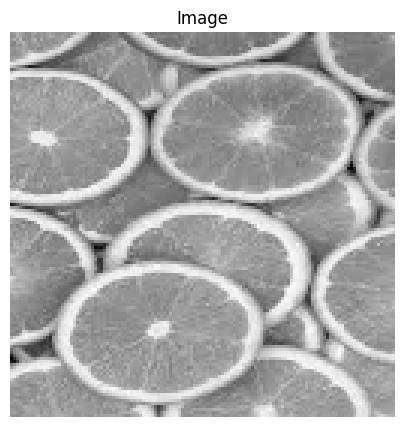

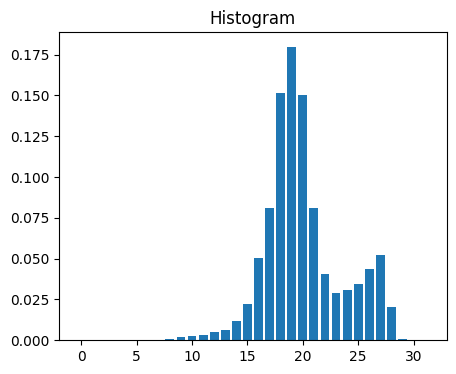

mean: 128.0000
variance: 782.6544
std_dev: 27.9760
skewness: 0.3858
kurtosis: 0.3233
energy: 0.1040
entropy: 2.5183


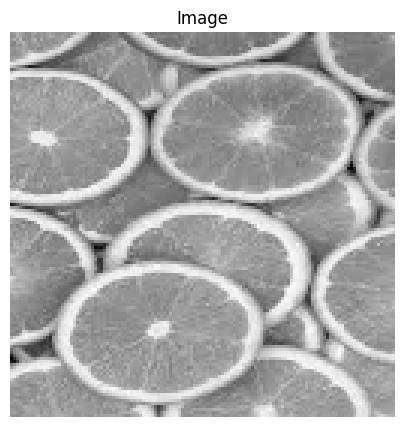

L5L5: 0.99747
E5L5: 0.00094
L5E5: 0.00056
R5L5: 0.00030
S5L5: 0.00019
L5R5: 0.00012
W5L5: 0.00010
L5S5: 0.00007


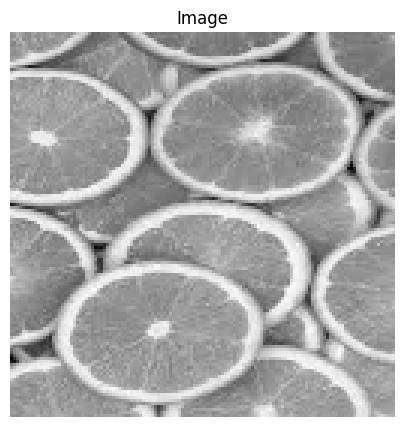

contrast: 5.5255
dissimilarity: 1.5382
homogeneity: 0.5156
energy: 0.1489
correlation: 0.7746
knn: accuracy=1.000, f1=1.000
svm: accuracy=1.000, f1=1.000
tree: accuracy=0.000, f1=0.000


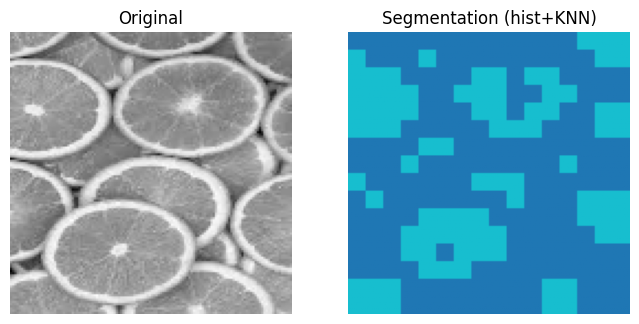

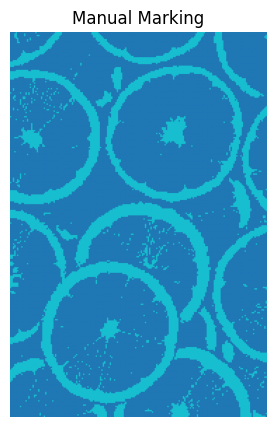

Accuracy: 48.711%
IoU per class:
  Class 0: 0.468
  Class 1: 0.067


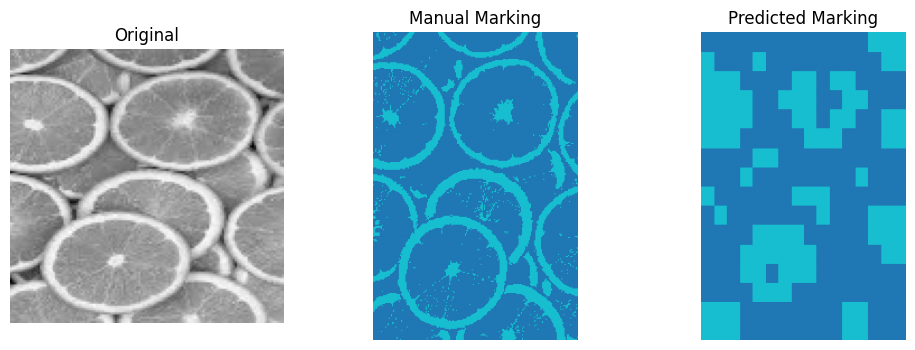

In [174]:
def run(image_path, dataset_folder):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img,(128,128))
    
    feats,hist = extract_hist_features(img)
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    plt.figure(figsize=(5,4)); plt.bar(range(len(hist)), hist); plt.title("Histogram"); plt.show()
    for k,v in feats.items(): print(f"{k}: {v:.4f}")

    feats_laws = laws_energy(img)
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    top = sorted(feats_laws.items(), key=lambda x:x[1], reverse=True)[:8]
    for k,v in top: print(f"{k}: {v:.5f}")

    feats_glcm = glcm_features(img)
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap='gray'); plt.title("Image"); plt.axis('off'); plt.show()
    for k,v in feats_glcm.items(): print(f"{k}: {v:.4f}")

    feature_mode = "hist"
    X,y = prepare_dataset(dataset_folder, feature_type=feature_mode)
    models, scaler, stats, le = train_classifiers(X,y)
    for name,info in stats.items(): print(f"{name}: accuracy={info['accuracy']:.3f}, f1={info['f1_macro']:.3f}")

    seg_map, orig_img = segment_image_by_texture(image_path, models["knn"], scaler, feature_mode, win=16, step=8)
    show_segmentation(seg_map, orig_img, title=f"Segmentation ({feature_mode}+KNN)")
    
    img_rgb = cv2.imread(image_path)
    manual = manual_mask_from_rgb(img_rgb)
    manual = map_top_n_classes(manual,n=4)
    plt.figure(figsize=(5,5)); plt.imshow(manual,cmap='tab10'); plt.title("Manual Marking"); plt.axis('off'); plt.show()

    evaluate_segmentation(manual, seg_map, orig_img)

DATA_ROOT = "/Users/aleksandrafanasev/Desktop/textures"
IMAGE_PATH = "/Users/aleksandrafanasev/Desktop/textures/class1/oranges_1.jpg"
run(IMAGE_PATH, DATA_ROOT)